In [ ]:
import torch
import torch.nn as nn
import firedrake as fd
import firedrake_adjoint  # noqa
import numpy as np
import ufl
from torchfire import fd_to_torch
import fdm
from fecr import evaluate_primal, evaluate_pullback
from torch.autograd import Variable
import torchviz
import matplotlib.pyplot as plt


class neural_net(torch.nn.Module):

    def __init__(self):
        super(neural_net, self).__init__()
        self.linear1 = nn.Linear(512 , 512)
        self.activation1 = nn.ReLU()
        self.linear2 = torch.nn.Linear(512, 512)
        #torch.nn.init.normal_(self.linear2.weight, mean=1.0, std=1.0)
        self.activation2 = nn.Sigmoid()
        self.float()

    def forward(self, x):
        x = torch.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        return x

def a_function(kappa):
    V = fd.FunctionSpace(mesh, "P", 1)
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V)

    u_sol = fd.Function(V)
    u_sol.interpolate(fd.sin(x[0] * fd.pi) * fd.sin( x[1] * fd.pi))

    kappa_sol = fd.Function(V)
    kappa_sol.interpolate( 1.0 / (1.0 + x[0]**2 + x[1]**2) )
    
    F.interpolate( fd.div(kappa_sol * fd.grad(u_sol  )))
    
    u = fd.Function(V)
    v = fd.TestFunction(V)
    bcs = [fd.DirichletBC(V, F, (1,))]

    a = (fd.inner( kappa * fd.grad(u), fd.grad(v))  - F * v  )* fd.dx

    fd.solve( a  == 0, u, bcs=bcs)
    return u

def u_solution(kappa):
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V)
    F.interpolate(fd.sin(x[0] * fd.pi) * fd.sin( x[1] * fd.pi))
    return F

def kappa_solution(kappa):
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V_kappa)
    F.interpolate( 1.0 / (1.0 + x[0]**2 + x[1]**2) )
    return F

In [ ]:
N = 128
mesh = fd.UnitSquareMesh(N, 2)
V = fd.FunctionSpace(mesh, "P", 1)
V_kappa = fd.FunctionSpace(mesh, "DG", 0)
x = fd.SpatialCoordinate(mesh)
print(V.dim())
print(V_kappa.dim())


In [ ]:
u_sol_templates = (fd.Function(V), )
u_sol_input = (torch.ones(V.dim(), requires_grad=False),)
u_sol = fd_to_torch(u_solution, u_sol_templates, "bob_u_sol")
u_sol_ = u_sol.apply(*u_sol_input)
u_sol_

In [ ]:
kappa_true_templates = (fd.Function(V_kappa), )
kappa_true_input = (torch.ones(V_kappa.dim(), requires_grad=False),)
kappa_true = fd_to_torch(kappa_solution, kappa_true_templates, "bob_kappa_sol")
kappa_true_ = kappa_true.apply(*kappa_true_input)
kappa_true_

In [ ]:
templates = (fd.Function(V_kappa),)
inputs = (torch.ones(V_kappa.dim(), requires_grad=True),)
a = fd_to_torch(a_function, templates, "bob_a")
a_ = a.apply


In [ ]:
error_L2 = nn.MSELoss()
learning_rate = 0.0001
kappa_nn = neural_net() #neural_net(N, 68, N)
optimizer = torch.optim.Adam(kappa_nn.parameters(), lr=learning_rate)
losses = []

for epoch in range(10000):
    print(f"Epoch:{epoch}")
    kappa = kappa_nn(*inputs)
    u = a_(kappa)

    loss = error_L2(u, u_sol_)
    grad_x, = torch.autograd.grad(loss, inputs, create_graph=True)
    torchviz.make_dot((grad_x, inputs[0] , loss), params={"grad_x": grad_x, "x": inputs[0], "out": loss}).render("attached",format="png")
    losses.append(loss)
    print(f"Loss:{loss}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot([loss.detach() for loss in losses][1:])
plt.savefig('losses.png')
plt.close()


In [ ]:
plt.plot([loss.detach() for loss in losses][1:])
#plt.savefig('losses.png')
#plt.close()

In [ ]:
print("kappa_nn: \n",kappa)

In [ ]:
print("kappa_true: \n",kappa_true_)

In [ ]:
kappa.detach().numpy() - kappa_true_.numpy()

In [ ]:
print("u_pred: \n",u)

In [ ]:
print("u_true: \n",u_sol_)

In [181]:
N = 128
mesh = fd.UnitSquareMesh(N, 2)
V = fd.FunctionSpace(mesh, "P", 1)
V_kappa = fd.FunctionSpace(mesh, "DG", 0)
x = fd.SpatialCoordinate(mesh)
print(V.dim())
print(V_kappa.dim())


387
512


In [182]:
u_sol_templates = (fd.Function(V), )
u_sol_input = (torch.ones(V.dim(), requires_grad=False),)
u_sol = fd_to_torch(u_solution, u_sol_templates, "bob_u_sol")
u_sol_ = u_sol.apply(*u_sol_input)
u_sol_

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4541e-02, 0.0000e+00, 0.0000e+00,
        4.9068e-02, 3.0054e-18, 0.0000e+00, 7.3565e-02, 6.0091e-18, 0.0000e+00,
        9.8017e-02, 9.0091e-18, 0.0000e+00, 1.2241e-01, 1.2004e-17, 0.0000e+00,
        1.4673e-01, 1.4991e-17, 0.0000e+00, 1.7096e-01, 1.7969e-17, 0.0000e+00,
        1.9509e-01, 2.0937e-17, 0.0000e+00, 2.1910e-01, 2.3892e-17, 0.0000e+00,
        2.4298e-01, 2.6832e-17, 0.0000e+00, 2.6671e-01, 2.9756e-17, 0.0000e+00,
        2.9028e-01, 3.2663e-17, 0.0000e+00, 3.1368e-01, 3.5550e-17, 0.0000e+00,
        3.3689e-01, 3.8415e-17, 0.0000e+00, 3.5990e-01, 4.1257e-17, 0.0000e+00,
        3.8268e-01, 4.4074e-17, 0.0000e+00, 4.0524e-01, 4.6865e-17, 0.0000e+00,
        4.2756e-01, 4.9628e-17, 0.0000e+00, 4.4961e-01, 5.2360e-17, 0.0000e+00,
        4.7140e-01, 5.5062e-17, 0.0000e+00, 4.9290e-01, 5.7729e-17, 0.0000e+00,
        5.1410e-01, 6.0363e-17, 0.0000e+00, 5.3500e-01, 6.2959e-17, 0.0000e+00,
        5.5557e-01, 6.5518e-17, 0.0000e+

In [183]:
kappa_true_templates = (fd.Function(V_kappa), )
kappa_true_input = (torch.ones(V_kappa.dim(), requires_grad=False),)
kappa_true = fd_to_torch(kappa_solution, kappa_true_templates, "bob_kappa_sol")
kappa_true_ = kappa_true.apply(*kappa_true_input)
kappa_true_

tensor([0.9730, 0.9000, 0.9729, 0.6923, 0.8999, 0.5902, 0.9727, 0.6923, 0.8996,
        0.5901, 0.9723, 0.6921, 0.8993, 0.5900, 0.9719, 0.6920, 0.8989, 0.5899,
        0.9713, 0.6918, 0.8984, 0.5897, 0.9707, 0.6915, 0.8978, 0.5895, 0.9699,
        0.6911, 0.8971, 0.5892, 0.9690, 0.6907, 0.8963, 0.5889, 0.9680, 0.6903,
        0.8954, 0.5886, 0.9668, 0.6898, 0.8944, 0.5882, 0.9656, 0.6892, 0.8933,
        0.5878, 0.9643, 0.6886, 0.8921, 0.5873, 0.9628, 0.6879, 0.8909, 0.5868,
        0.9612, 0.6871, 0.8895, 0.5862, 0.9596, 0.6863, 0.8880, 0.5856, 0.9578,
        0.6855, 0.8865, 0.5850, 0.9559, 0.6846, 0.8848, 0.5843, 0.9539, 0.6836,
        0.8831, 0.5836, 0.9518, 0.6826, 0.8813, 0.5828, 0.9497, 0.6815, 0.8794,
        0.5821, 0.9474, 0.6804, 0.8774, 0.5812, 0.9450, 0.6792, 0.8753, 0.5804,
        0.9425, 0.6780, 0.8731, 0.5794, 0.9399, 0.6767, 0.8709, 0.5785, 0.9373,
        0.6754, 0.8686, 0.5775, 0.9345, 0.6740, 0.8662, 0.5765, 0.9316, 0.6726,
        0.8637, 0.5754, 0.9287, 0.6711, 

In [184]:
templates = (fd.Function(V_kappa),)
inputs = (torch.ones(V_kappa.dim(), requires_grad=True),)
a = fd_to_torch(a_function, templates, "bob_a")
a_ = a.apply


In [186]:
error_L2 = nn.MSELoss()
learning_rate = 0.0001
kappa_nn = neural_net() #neural_net(N, 68, N)
optimizer = torch.optim.Adam(kappa_nn.parameters(), lr=learning_rate)
losses = []

for epoch in range(10000):
    print(f"Epoch:{epoch}")
    kappa = kappa_nn(*inputs)
    u = a_(kappa)

    loss = error_L2(u, u_sol_)
    grad_x, = torch.autograd.grad(loss, inputs, create_graph=True)
    torchviz.make_dot((grad_x, inputs[0] , loss), params={"grad_x": grad_x, "x": inputs[0], "out": loss}).render("attached",format="png")
    losses.append(loss)
    print(f"Loss:{loss}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot([loss.detach() for loss in losses][1:])
plt.savefig('losses.png')
plt.close()


Epoch:0
Loss:0.17594383467700833
Epoch:1
Loss:0.17358716685568037
Epoch:2
Loss:0.17143483892543623
Epoch:3
Loss:0.16943594589890582
Epoch:4
Loss:0.16755307972467587
Epoch:5
Loss:0.1657746876614598
Epoch:6
Loss:0.16406850997042866
Epoch:7
Loss:0.1624255514300089
Epoch:8
Loss:0.1608274380298438
Epoch:9
Loss:0.15926337090175186
Epoch:10
Loss:0.1577405879152399
Epoch:11
Loss:0.15625117098225702
Epoch:12
Loss:0.15478688136981428
Epoch:13
Loss:0.15334338886045182
Epoch:14
Loss:0.15191772026722636
Epoch:15
Loss:0.15051363036797166
Epoch:16
Loss:0.1491336382580585
Epoch:17
Loss:0.14778233873880778
Epoch:18
Loss:0.14646448146208976
Epoch:19
Loss:0.14518457117459208
Epoch:20
Loss:0.14394665603361986
Epoch:21
Loss:0.1427541974610274
Epoch:22
Loss:0.14161131930753554
Epoch:23
Loss:0.14052061793910214
Epoch:24
Loss:0.13948402863050294
Epoch:25
Loss:0.13850278569018862
Epoch:26
Loss:0.13757744446387377
Epoch:27
Loss:0.13670789187926172
Epoch:28
Loss:0.13589352011825717
Epoch:29
Loss:0.13513319985545

Epoch:242
Loss:0.12553476539800745
Epoch:243
Loss:0.12553441807284704
Epoch:244
Loss:0.12553407858722507
Epoch:245
Loss:0.1255337472530578
Epoch:246
Loss:0.1255334233450756
Epoch:247
Loss:0.12553310716317614
Epoch:248
Loss:0.12553279832174505
Epoch:249
Loss:0.12553249689087867
Epoch:250
Loss:0.12553220239086674
Epoch:251
Loss:0.12553191479163117
Epoch:252
Loss:0.12553163408607138
Epoch:253
Loss:0.12553136023299932
Epoch:254
Loss:0.12553109260693046
Epoch:255
Loss:0.12553083155236222
Epoch:256
Loss:0.12553057659179687
Epoch:257
Loss:0.1255303278776859
Epoch:258
Loss:0.12553008496999155
Epoch:259
Loss:0.12552984822877677
Epoch:260
Loss:0.12552961723615594
Epoch:261
Loss:0.1255293916223752
Epoch:262
Loss:0.1255291716693126
Epoch:263
Loss:0.12552895713809373
Epoch:264
Loss:0.12552874767675254
Epoch:265
Loss:0.1255285434582834
Epoch:266
Loss:0.12552834422899287
Epoch:267
Loss:0.12552814997926798
Epoch:268
Loss:0.1255279605225709
Epoch:269
Loss:0.12552777589730316
Epoch:270
Loss:0.1255275958

Loss:0.12552131100640584
Epoch:481
Loss:0.12552131090907534
Epoch:482
Loss:0.12552131079576295
Epoch:483
Loss:0.12552131068897568
Epoch:484
Loss:0.12552131062363164
Epoch:485
Loss:0.1255213105130505
Epoch:486
Loss:0.12552131031271518
Epoch:487
Loss:0.12552131020523744
Epoch:488
Loss:0.12552131018267684
Epoch:489
Loss:0.1255213101078073
Epoch:490
Loss:0.12552130992874985
Epoch:491
Loss:0.12552130982947418
Epoch:492
Loss:0.12552130973458783
Epoch:493
Loss:0.12552130968608322
Epoch:494
Loss:0.12552130949301724
Epoch:495
Loss:0.12552130944249046
Epoch:496
Loss:0.12552130937310688
Epoch:497
Loss:0.1255213093046107
Epoch:498
Loss:0.12552130921619764
Epoch:499
Loss:0.12552130920713997
Epoch:500
Loss:0.12552130911593268
Epoch:501
Loss:0.1255213090697926
Epoch:502
Loss:0.12552130903075484
Epoch:503
Loss:0.12552130897742805
Epoch:504
Loss:0.12552130881049497
Epoch:505
Loss:0.1255213087040722
Epoch:506
Loss:0.1255213086342704
Epoch:507
Loss:0.12552130859717303
Epoch:508
Loss:0.12552130852621207
E

Loss:0.12552130168517747
Epoch:717
Loss:0.12552130168377937
Epoch:718
Loss:0.12552130168174258
Epoch:719
Loss:0.12552130163362252
Epoch:720
Loss:0.12552130162435404
Epoch:721
Loss:0.12552130164535422
Epoch:722
Loss:0.12552130162099695
Epoch:723
Loss:0.12552130161502412
Epoch:724
Loss:0.12552130161237032
Epoch:725
Loss:0.12552130160412384
Epoch:726
Loss:0.1255213015980602
Epoch:727
Loss:0.12552130158262978
Epoch:728
Loss:0.12552130156270314
Epoch:729
Loss:0.1255213015388984
Epoch:730
Loss:0.12552130152548094
Epoch:731
Loss:0.1255213015179597
Epoch:732
Loss:0.12552130150447252
Epoch:733
Loss:0.1255213014909251
Epoch:734
Loss:0.12552130150411997
Epoch:735
Loss:0.1255213014732691
Epoch:736
Loss:0.12552130145981383
Epoch:737
Loss:0.12552130146163315
Epoch:738
Loss:0.12552130145638882
Epoch:739
Loss:0.12552130140049664
Epoch:740
Loss:0.1255213014161365
Epoch:741
Loss:0.12552130142187215
Epoch:742
Loss:0.12552130142835816
Epoch:743
Loss:0.12552130140618445
Epoch:744
Loss:0.12552130140345957
E

Epoch:953
Loss:0.12552129983637297
Epoch:954
Loss:0.12552129983528895
Epoch:955
Loss:0.12552129983504123
Epoch:956
Loss:0.1255212998287528
Epoch:957
Loss:0.12552129981359114
Epoch:958
Loss:0.125521299802803
Epoch:959
Loss:0.125521299788868
Epoch:960
Loss:0.12552129978961357
Epoch:961
Loss:0.12552129978989088
Epoch:962
Loss:0.12552129978537765
Epoch:963
Loss:0.12552129977197282
Epoch:964
Loss:0.12552129978250004
Epoch:965
Loss:0.1255212997938157
Epoch:966
Loss:0.12552129979907878
Epoch:967
Loss:0.12552129979886562
Epoch:968
Loss:0.12552129979107662
Epoch:969
Loss:0.12552129978563656
Epoch:970
Loss:0.12552129978634483
Epoch:971
Loss:0.12552129979099613
Epoch:972
Loss:0.1255212998092284
Epoch:973
Loss:0.12552129980122062
Epoch:974
Loss:0.12552129980109358
Epoch:975
Loss:0.12552129978480073
Epoch:976
Loss:0.1255212997750988
Epoch:977
Loss:0.12552129977453866
Epoch:978
Loss:0.1255212997772302
Epoch:979
Loss:0.12552129975916293
Epoch:980
Loss:0.1255212997523294
Epoch:981
Loss:0.1255212997416

Epoch:1185
Loss:0.12552129905293075
Epoch:1186
Loss:0.12552129901694625
Epoch:1187
Loss:0.12552129901681794
Epoch:1188
Loss:0.1255212989927164
Epoch:1189
Loss:0.12552129899254524
Epoch:1190
Loss:0.1255212989925027
Epoch:1191
Loss:0.12552129898856743
Epoch:1192
Loss:0.12552129898843983
Epoch:1193
Loss:0.1255212989883502
Epoch:1194
Loss:0.12552129900588885
Epoch:1195
Loss:0.12552129900576103
Epoch:1196
Loss:0.12552129900585793
Epoch:1197
Loss:0.12552129900564504
Epoch:1198
Loss:0.12552129900437206
Epoch:1199
Loss:0.125521298993396
Epoch:1200
Loss:0.12552129900438092
Epoch:1201
Loss:0.12552129900425374
Epoch:1202
Loss:0.12552129899806594
Epoch:1203
Loss:0.12552129899793874
Epoch:1204
Loss:0.12552129899432804
Epoch:1205
Loss:0.12552129899428527
Epoch:1206
Loss:0.1255212989942006
Epoch:1207
Loss:0.12552129899816225
Epoch:1208
Loss:0.12552129899803433
Epoch:1209
Loss:0.1255212989960648
Epoch:1210
Loss:0.12552129899542863
Epoch:1211
Loss:0.12552129898993925
Epoch:1212
Loss:0.1255212989876457


Epoch:1415
Loss:0.12552129862402556
Epoch:1416
Loss:0.12552129864608066
Epoch:1417
Loss:0.1255212986459526
Epoch:1418
Loss:0.12552129864590644
Epoch:1419
Loss:0.1255212986457781
Epoch:1420
Loss:0.1255212986457781
Epoch:1421
Loss:0.1255212986457781
Epoch:1422
Loss:0.12552129868407522
Epoch:1423
Loss:0.12552129868398984
Epoch:1424
Loss:0.12552129868394726
Epoch:1425
Loss:0.12552129869815196
Epoch:1426
Loss:0.12552129870234685
Epoch:1427
Loss:0.12552129870230408
Epoch:1428
Loss:0.1255212987071268
Epoch:1429
Loss:0.12552129870704076
Epoch:1430
Loss:0.1255212986827643
Epoch:1431
Loss:0.12552129868264453
Epoch:1432
Loss:0.12552129866483172
Epoch:1433
Loss:0.12552129866868844
Epoch:1434
Loss:0.12552129866860348
Epoch:1435
Loss:0.1255212986577179
Epoch:1436
Loss:0.12552129864790995
Epoch:1437
Loss:0.12552129864653389
Epoch:1438
Loss:0.1255212986452859
Epoch:1439
Loss:0.12552129864517736
Epoch:1440
Loss:0.12552129863474873
Epoch:1441
Loss:0.12552129863466333
Epoch:1442
Loss:0.12552129862987638


Loss:0.12552129845767696
Epoch:1646
Loss:0.12552129845767696
Epoch:1647
Loss:0.12552129844942
Epoch:1648
Loss:0.1255212984493346
Epoch:1649
Loss:0.1255212984493346
Epoch:1650
Loss:0.12552129844924975
Epoch:1651
Loss:0.12552129844924975
Epoch:1652
Loss:0.12552129844924975
Epoch:1653
Loss:0.125521298449214
Epoch:1654
Loss:0.12552129845706175
Epoch:1655
Loss:0.12552129845697615
Epoch:1656
Loss:0.12552129845697615
Epoch:1657
Loss:0.12552129845697615
Epoch:1658
Loss:0.12552129842309062
Epoch:1659
Loss:0.12552129842300516
Epoch:1660
Loss:0.12552129842300516
Epoch:1661
Loss:0.12552129842300516
Epoch:1662
Loss:0.12552129842300516
Epoch:1663
Loss:0.12552129842291979
Epoch:1664
Loss:0.12552129842291979
Epoch:1665
Loss:0.12552129842287754
Epoch:1666
Loss:0.12552129842287754
Epoch:1667
Loss:0.12552129842287754
Epoch:1668
Loss:0.12552129841263107
Epoch:1669
Loss:0.12552129841263107
Epoch:1670
Loss:0.12552129841254725
Epoch:1671
Loss:0.12552129841240015
Epoch:1672
Loss:0.12552129841240015
Epoch:1673

Loss:0.1255212983212716
Epoch:1876
Loss:0.12552129831932948
Epoch:1877
Loss:0.12552129831932948
Epoch:1878
Loss:0.12552129831932948
Epoch:1879
Loss:0.1255212983192863
Epoch:1880
Loss:0.1255212983192863
Epoch:1881
Loss:0.12552129831920117
Epoch:1882
Loss:0.12552129831920117
Epoch:1883
Loss:0.12552129831920117
Epoch:1884
Loss:0.12552129831920117
Epoch:1885
Loss:0.1255212983117025
Epoch:1886
Loss:0.1255212983116603
Epoch:1887
Loss:0.1255212983116603
Epoch:1888
Loss:0.12552129831157458
Epoch:1889
Loss:0.12552129831157458
Epoch:1890
Loss:0.12552129831153913
Epoch:1891
Loss:0.12552129831153913
Epoch:1892
Loss:0.12552129831153913
Epoch:1893
Loss:0.12552129830472838
Epoch:1894
Loss:0.1255212982926327
Epoch:1895
Loss:0.1255212982926327
Epoch:1896
Loss:0.12552129829258973
Epoch:1897
Loss:0.12552129829258973
Epoch:1898
Loss:0.12552129829258973
Epoch:1899
Loss:0.12552129829258973
Epoch:1900
Loss:0.12552129829258973
Epoch:1901
Loss:0.12552129829250522
Epoch:1902
Loss:0.12552129829250522
Epoch:1903


Loss:0.12552129820929783
Epoch:2107
Loss:0.12552129820921298
Epoch:2108
Loss:0.12552129820921298
Epoch:2109
Loss:0.12552129820921298
Epoch:2110
Loss:0.12552129820921298
Epoch:2111
Loss:0.12552129820921298
Epoch:2112
Loss:0.12552129820916944
Epoch:2113
Loss:0.12552129820916944
Epoch:2114
Loss:0.12552129820908442
Epoch:2115
Loss:0.12552129820908442
Epoch:2116
Loss:0.12552129820908442
Epoch:2117
Loss:0.12552129820908442
Epoch:2118
Loss:0.12552129820858918
Epoch:2119
Loss:0.12552129820854774
Epoch:2120
Loss:0.125521298208059
Epoch:2121
Loss:0.125521298208059
Epoch:2122
Loss:0.12552129820793956
Epoch:2123
Loss:0.12552129820786415
Epoch:2124
Loss:0.12552129820786415
Epoch:2125
Loss:0.12552129820786415
Epoch:2126
Loss:0.1255212982103057
Epoch:2127
Loss:0.1255212982102636
Epoch:2128
Loss:0.12552129820764438
Epoch:2129
Loss:0.12552129820131752
Epoch:2130
Loss:0.12552129820131752
Epoch:2131
Loss:0.12552129820131752
Epoch:2132
Loss:0.12552129819924163
Epoch:2133
Loss:0.1255212982041863
Epoch:2134

Epoch:2337
Loss:0.12552129813305474
Epoch:2338
Loss:0.12552129813305474
Epoch:2339
Loss:0.12552129813305474
Epoch:2340
Loss:0.12552129813305474
Epoch:2341
Loss:0.12552129813305474
Epoch:2342
Loss:0.12552129813305474
Epoch:2343
Loss:0.12552129813305474
Epoch:2344
Loss:0.12552129813296906
Epoch:2345
Loss:0.12552129813296906
Epoch:2346
Loss:0.12552129813296906
Epoch:2347
Loss:0.12552129813296906
Epoch:2348
Loss:0.12552129813288415
Epoch:2349
Loss:0.12552129813288415
Epoch:2350
Loss:0.12552129813288415
Epoch:2351
Loss:0.12552129813288415
Epoch:2352
Loss:0.12552129813288415
Epoch:2353
Loss:0.12552129813288415
Epoch:2354
Loss:0.12552129813288415
Epoch:2355
Loss:0.12552129813288415
Epoch:2356
Loss:0.12552129813288415
Epoch:2357
Loss:0.12552129813288415
Epoch:2358
Loss:0.12552129813288415
Epoch:2359
Loss:0.12552129813288415
Epoch:2360
Loss:0.12552129813275625
Epoch:2361
Loss:0.12552129813268673
Epoch:2362
Loss:0.12552129813268673
Epoch:2363
Loss:0.12552129813264098
Epoch:2364
Loss:0.1255212981

Loss:0.1255212981410828
Epoch:2570
Loss:0.1255212981410828
Epoch:2571
Loss:0.1255212981410828
Epoch:2572
Loss:0.1255212981410828
Epoch:2573
Loss:0.1255212981410828
Epoch:2574
Loss:0.12552129814099738
Epoch:2575
Loss:0.1255212981426795
Epoch:2576
Loss:0.12552129814259363
Epoch:2577
Loss:0.12552129814259363
Epoch:2578
Loss:0.12552129814259363
Epoch:2579
Loss:0.12552129814259363
Epoch:2580
Loss:0.12552129814259363
Epoch:2581
Loss:0.12552129814259363
Epoch:2582
Loss:0.12552129814259363
Epoch:2583
Loss:0.12552129814259363
Epoch:2584
Loss:0.12552129814259363
Epoch:2585
Loss:0.12552129814259363
Epoch:2586
Loss:0.12552129814259363
Epoch:2587
Loss:0.12552129814259363
Epoch:2588
Loss:0.12552129814259363
Epoch:2589
Loss:0.12552129814144958
Epoch:2590
Loss:0.12552129814132124
Epoch:2591
Loss:0.12552129814132124
Epoch:2592
Loss:0.12552129814132124
Epoch:2593
Loss:0.12552129814132124
Epoch:2594
Loss:0.12552129814132124
Epoch:2595
Loss:0.12552129814132124
Epoch:2596
Loss:0.12552129814132124
Epoch:259

Epoch:2800
Loss:0.1255212981347366
Epoch:2801
Loss:0.1255212981347366
Epoch:2802
Loss:0.1255212981347366
Epoch:2803
Loss:0.1255212981347366
Epoch:2804
Loss:0.1255212981347366
Epoch:2805
Loss:0.1255212981347366
Epoch:2806
Loss:0.12552129813465146
Epoch:2807
Loss:0.12552129813465146
Epoch:2808
Loss:0.12552129813465146
Epoch:2809
Loss:0.12552129813465146
Epoch:2810
Loss:0.12552129813465146
Epoch:2811
Loss:0.12552129813465146
Epoch:2812
Loss:0.12552129813465146
Epoch:2813
Loss:0.12552129813465146
Epoch:2814
Loss:0.12552129813465146
Epoch:2815
Loss:0.12552129813465146
Epoch:2816
Loss:0.12552129813465146
Epoch:2817
Loss:0.12552129813465146
Epoch:2818
Loss:0.12552129813465146
Epoch:2819
Loss:0.12552129813461707
Epoch:2820
Loss:0.12552129813461707
Epoch:2821
Loss:0.12552129813461707
Epoch:2822
Loss:0.12552129813461707
Epoch:2823
Loss:0.12552129813453158
Epoch:2824
Loss:0.12552129813453158
Epoch:2825
Loss:0.12552129813453158
Epoch:2826
Loss:0.12552129813453158
Epoch:2827
Loss:0.1255212981345315

KeyboardInterrupt: 

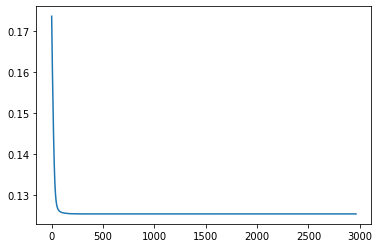

In [187]:
plt.plot([loss.detach() for loss in losses][1:])
#plt.savefig('losses.png')
#plt.close()

In [188]:
print("kappa_nn: \n",kappa)

kappa_nn: 
 tensor([0.9312, 0.9508, 0.9294, 0.7927, 0.8667, 0.8981, 0.9220, 0.8978, 0.9423,
        0.9698, 0.9042, 0.9678, 0.9320, 0.9275, 0.9710, 0.9041, 0.9474, 0.9265,
        0.9495, 0.8402, 0.9545, 0.9616, 0.9227, 0.8999, 0.9283, 0.9531, 0.8658,
        0.8991, 0.9331, 0.9155, 0.8535, 0.8488, 0.9048, 0.8927, 0.9380, 0.8470,
        0.9667, 0.9609, 0.8943, 0.9035, 0.9559, 0.9160, 0.9587, 0.9625, 0.9766,
        0.8957, 0.8598, 0.9783, 0.8531, 0.9266, 0.9321, 0.9652, 0.9864, 0.7860,
        0.7941, 0.9504, 0.9738, 0.8882, 0.9211, 0.9774, 0.9234, 0.9644, 0.9617,
        0.9645, 0.7744, 0.9093, 0.8053, 0.9302, 0.8124, 0.8557, 0.9159, 0.9138,
        0.9547, 0.8642, 0.9109, 0.9182, 0.8925, 0.9341, 0.8676, 0.8952, 0.9197,
        0.9088, 0.8454, 0.8633, 0.8887, 0.8752, 0.8296, 0.9010, 0.8928, 0.9071,
        0.9529, 0.9296, 0.9212, 0.9461, 0.9680, 0.8521, 0.9265, 0.9514, 0.9343,
        0.9930, 0.9410, 0.8798, 0.9518, 0.8708, 0.9251, 0.9742, 0.9059, 0.9540,
        0.9317, 0.9651, 0.93

In [189]:
print("kappa_true: \n",kappa_true_)

kappa_true: 
 tensor([0.9730, 0.9000, 0.9729, 0.6923, 0.8999, 0.5902, 0.9727, 0.6923, 0.8996,
        0.5901, 0.9723, 0.6921, 0.8993, 0.5900, 0.9719, 0.6920, 0.8989, 0.5899,
        0.9713, 0.6918, 0.8984, 0.5897, 0.9707, 0.6915, 0.8978, 0.5895, 0.9699,
        0.6911, 0.8971, 0.5892, 0.9690, 0.6907, 0.8963, 0.5889, 0.9680, 0.6903,
        0.8954, 0.5886, 0.9668, 0.6898, 0.8944, 0.5882, 0.9656, 0.6892, 0.8933,
        0.5878, 0.9643, 0.6886, 0.8921, 0.5873, 0.9628, 0.6879, 0.8909, 0.5868,
        0.9612, 0.6871, 0.8895, 0.5862, 0.9596, 0.6863, 0.8880, 0.5856, 0.9578,
        0.6855, 0.8865, 0.5850, 0.9559, 0.6846, 0.8848, 0.5843, 0.9539, 0.6836,
        0.8831, 0.5836, 0.9518, 0.6826, 0.8813, 0.5828, 0.9497, 0.6815, 0.8794,
        0.5821, 0.9474, 0.6804, 0.8774, 0.5812, 0.9450, 0.6792, 0.8753, 0.5804,
        0.9425, 0.6780, 0.8731, 0.5794, 0.9399, 0.6767, 0.8709, 0.5785, 0.9373,
        0.6754, 0.8686, 0.5775, 0.9345, 0.6740, 0.8662, 0.5765, 0.9316, 0.6726,
        0.8637, 0.5754, 0.

In [190]:
kappa.detach().numpy() - kappa_true_.numpy()

array([-0.04181379,  0.05078997, -0.04343644,  0.10044425, -0.03315006,
        0.30791108, -0.05063913,  0.20549791,  0.04264304,  0.37970911,
       -0.068103  ,  0.27561663,  0.03261493,  0.33746569, -0.00093579,
        0.21208888,  0.04848059,  0.3365761 , -0.02187319,  0.14841855,
        0.05609029,  0.37186153, -0.04792002,  0.20845126,  0.0304647 ,
        0.36363926, -0.10404615,  0.20800413,  0.03599217,  0.3262828 ,
       -0.1154713 ,  0.15810539,  0.00844817,  0.30381311, -0.02994079,
        0.15668037,  0.07126554,  0.37237099, -0.07255995,  0.21376437,
        0.06150504,  0.32781908, -0.00689415,  0.2732542 ,  0.0832396 ,
        0.30791042, -0.10446547,  0.289708  , -0.03898728,  0.33935146,
       -0.03067642,  0.27735332,  0.09555091,  0.19919725, -0.1671508 ,
        0.26321792,  0.08427767,  0.30201946, -0.03844888,  0.29101677,
        0.03536026,  0.37880827,  0.00387099,  0.27897281, -0.11209841,
        0.32434293, -0.15058704,  0.24565109, -0.07239041,  0.27

In [191]:
print("u_pred: \n",u)

u_pred: 
 tensor([-0.0000, -0.0157,  0.0027, -0.0111,  0.0053,  0.0294, -0.0065,  0.0335,
         0.0080, -0.0024,  0.0372,  0.0108,  0.0020,  0.0411,  0.0134,  0.0064,
         0.0451,  0.0160,  0.0107,  0.0489,  0.0187,  0.0150,  0.0527,  0.0217,
         0.0195,  0.0568,  0.0246,  0.0239,  0.0609,  0.0273,  0.0281,  0.0648,
         0.0302,  0.0322,  0.0688,  0.0329,  0.0362,  0.0730,  0.0359,  0.0405,
         0.0770,  0.0386,  0.0445,  0.0817,  0.0419,  0.0485,  0.0859,  0.0447,
         0.0526,  0.0898,  0.0474,  0.0571,  0.0939,  0.0506,  0.0616,  0.0983,
         0.0535,  0.0657,  0.1026,  0.0564,  0.0700,  0.1066,  0.0594,  0.0743,
         0.1107,  0.0626,  0.0786,  0.1150,  0.0658,  0.0828,  0.1190,  0.0685,
         0.0871,  0.1230,  0.0713,  0.0910,  0.1268,  0.0742,  0.0952,  0.1310,
         0.0770,  0.0992,  0.1348,  0.0800,  0.1032,  0.1386,  0.0829,  0.1072,
         0.1426,  0.0858,  0.1113,  0.1467,  0.0888,  0.1157,  0.1506,  0.0920,
         0.1198,  0.1546,  0.0

In [192]:
print("u_true: \n",u_sol_)

u_true: 
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4541e-02, 0.0000e+00, 0.0000e+00,
        4.9068e-02, 3.0054e-18, 0.0000e+00, 7.3565e-02, 6.0091e-18, 0.0000e+00,
        9.8017e-02, 9.0091e-18, 0.0000e+00, 1.2241e-01, 1.2004e-17, 0.0000e+00,
        1.4673e-01, 1.4991e-17, 0.0000e+00, 1.7096e-01, 1.7969e-17, 0.0000e+00,
        1.9509e-01, 2.0937e-17, 0.0000e+00, 2.1910e-01, 2.3892e-17, 0.0000e+00,
        2.4298e-01, 2.6832e-17, 0.0000e+00, 2.6671e-01, 2.9756e-17, 0.0000e+00,
        2.9028e-01, 3.2663e-17, 0.0000e+00, 3.1368e-01, 3.5550e-17, 0.0000e+00,
        3.3689e-01, 3.8415e-17, 0.0000e+00, 3.5990e-01, 4.1257e-17, 0.0000e+00,
        3.8268e-01, 4.4074e-17, 0.0000e+00, 4.0524e-01, 4.6865e-17, 0.0000e+00,
        4.2756e-01, 4.9628e-17, 0.0000e+00, 4.4961e-01, 5.2360e-17, 0.0000e+00,
        4.7140e-01, 5.5062e-17, 0.0000e+00, 4.9290e-01, 5.7729e-17, 0.0000e+00,
        5.1410e-01, 6.0363e-17, 0.0000e+00, 5.3500e-01, 6.2959e-17, 0.0000e+00,
        5.5557e-01, 6.5518e-17